# Modelling and scalability analysis

This notebook implements a systematic scalability evaluation of four fraud-detection models—Logistic Regression, LightGBM, Isolation Forest, and Random Forest—running on Apache Spark in a GCP Dataproc cluster. 

1. **Data Sampling & Partitioning**  
   - For each target fraction (e.g. 5 %, 25 %, 100 % of the full 4 M-row training set), we stratify-sample to preserve the 0.17 % fraud rate. 
   - Each sampled DataFrame is repartitioned into 16 partitions and cached.
   
2. **Model Definition**  
   - A shared `VectorAssembler` converts the feature columns into a single `features` vector.  
   - Four separate `Pipeline` objects encapsulate each algorithm’s hyperparameters and training logic.

3. **Training & Evaluation Loop**  
   - We iterate over each sample fraction and model pipeline:  
     1. **Fit** the pipeline on the sampled training data and record training time.  
     2. **Transform** the hold-out test set to generate predictions and probability/anomaly scores.  
     3. **Pull** the relevant columns into Pandas and compute classification metrics (accuracy, precision, recall, F1, ROC-AUC, PR-AUC).  
     4. **Log** all timings, metrics, and partition counts into a master DataFrame.

4. **System Metrics Collection**  
   - After model runs, we fetch cluster resource metrics (CPU utilization, disk I/O, memory and YARN allocation) via the GCP Monitoring UI for the same time window, enabling joint analysis of compute performance and resource usage.

By automating these steps, we obtain a complete runtime and accuracy profile across data scales and algorithms, allowing us to pinpoint where model performance, training speed, and cluster efficiency intersect.

## Cluster configuration settings

We used the following command to instantiate our cluster in the GCP Cloud Shell.

We spin up two separate clusters, one with 2 worker nodes and the other with 4 worker nodes to test scalability.

```
gcloud dataproc clusters create st446-final-proj \
  --region=europe-west2 \
  --zone=europe-west2-c \
  --master-machine-type=n2-standard-2 \
  --master-boot-disk-type=pd-balanced \
  --master-boot-disk-size=100 \
  --num-workers=2 \
  --worker-machine-type=n2-standard-2 \
  --worker-boot-disk-type=pd-balanced \
  --worker-boot-disk-size=100 \
  --image-version=2.2-debian12 \
  --optional-components=JUPYTER \
  --enable-component-gateway \
  --public-ip-address \
  --project=st446-wt2025-id \
  --properties='^#^spark:spark.jars.packages=com.microsoft.azure:synapseml_2.12:0.11.1,ml.dmlc:xgboost4j-spark_2.12:1.6.0'
```

Once the cluster is instantiated, we also create a bucket and upload the final training and testing data in it. 

```
gsutil mb gs://st446-final-bucket
```

## Import packages/libraries + setup

In [1]:
from datetime import datetime, timezone
import time
import requests
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql import SparkSession

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from synapse.ml.isolationforest import IsolationForest
from synapse.ml.lightgbm import LightGBMClassifier  
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)

## Capture the start time

Throughout the code, you we print time-stamps so we are later able to filter computing environment metrics in the GCP Cluster Monitoring UI to the exact moments we are running the analysis.

In [2]:
run_start = datetime.now(timezone.utc)
print("Start time (UTC): ", run_start)

# list to accumulate operation timings
_cell_times = []

Start time (UTC):  2025-05-05 21:45:07.020738+00:00


In [3]:
# this will check that Spark is working ok
spark.range(1).count()

1

## Load the data and perform some basic checks

In [4]:
# Load data
start = datetime.now(timezone.utc) #start

train_df = spark.read.csv("gs://st446-final-bucket/final_training_data.csv", header=True, inferSchema=True)
test_df = spark.read.csv("gs://st446-final-bucket/test_data.csv", header=True, inferSchema=True)

end   = datetime.now(timezone.utc) #end
_cell_times.append({
    "operation": "test",
    "start":     start,
    "end":       end
})

## Dataset Composition & Class Imbalance

- **Original data** consisted of 284,807 transactions with only 492 frauds (~0.17% fraud rate).  
- **Training set (~4,000,000 rows)** 
  - We applied SMOTE plus bootstrap-with-jitter to the 80% training split, boosting the minority (“fraud”) class from 0.17% up to roughly 25% of the augmented training data.  
  - This yields 3,998,559 total rows, with ~1,000,856 frauds (25.0%) and ~2,998,703 non-frauds (75.0 %).  
  - **Why 25%?**  Oversampling to a moderate fraud proportion prevents extreme class imbalance in the learners’ objective functions while still preserving realistic negative examples.

- **Test set (56,624 rows)**  
  - Left untouched at the original 20% hold-out it retains the real-world distribution: 93 frauds (~0.17%) vs. 56,531 non-frauds (~99.83%).  
  - **Why keep it skewed?**  We measure PR-AUC, precision, and recall on genuinely imbalanced data so our evaluation reflects true operational performance, not the synthetic training balance.

By training on a balanced 25% fraud ratio and testing on the true 0.17 % rate, we ensure our models learn from enough positive examples without overstating their production-time effectiveness.```

In [5]:
# materialise caches
train_rows = train_df.count()
test_rows  = test_df.count()

train_df = train_df.withColumnRenamed("Class", "label")
test_df = test_df.withColumnRenamed("Class", "label")

print("Training Rows:", train_rows) 
print("Training class breakdown:")
train_df.groupBy("label") \
   .count() \
   .withColumn("share_%", F.round(F.col("count") / train_df.count() * 100, 3)) \
   .show()

print("Testing Rows:", test_rows)     
print("Testing class breakdown:")
test_df.groupBy("label") \
   .count() \
   .withColumn("share_%", F.round(F.col("count") / test_df.count() * 100, 3)) \
   .show()

Training Rows: 3999559
Training class breakdown:


+-----+-------+-------+
|label|  count|share_%|
+-----+-------+-------+
|    0|2998703| 74.976|
|    1|1000856| 25.024|
+-----+-------+-------+

Testing Rows: 56624
Testing class breakdown:


+-----+-----+-------+
|label|count|share_%|
+-----+-----+-------+
|    1|   93|  0.164|
|    0|56531| 99.836|
+-----+-----+-------+



## Model Pipelines Overview

We define four separate Spark ML pipelines—each sharing a common feature‐assembly step—to compare linear, tree-based, and anomaly-detection approaches.

**Note:** We deliberately did not perform exhaustive hyperparameter tuning here—our goal was to measure how training time and resource usage scale with data size and cluster configuration, rather than to maximize model accuracy. Hyperparameter optimization could be a natural next step once we’ve identified the best-performing algorithms and cluster settings.

1. **Feature Assembly**  
   - `VectorAssembler` takes all numeric PCA‐derived features (excluding `label` and `Time`) and produces a single `features` vector for each transaction.

2. **Logistic Regression**  
   - **Estimator**: `LogisticRegression`  
   - **Key settings**:  
     - `regParam=0.1`, `elasticNetParam=0.5` for balanced L1/L2 regularization  
     - Produces `probability` and `prediction` columns  
   - **Use-case**: Fast, calibrated linear baseline on PCA data.

3. **LightGBM (Gradient Boosted Trees)**  
   - **Estimator**: `LightGBMClassifier`  
   - **Key settings**:  
     - `numIterations=100`, `learningRate=0.05`  
     - `numLeaves=32`, `featureFraction=0.8`, `baggingFraction=0.8`, `baggingFreq=1`  
     - `isUnbalance=True`, `seed=42` for reproducibility  
   - **Use-case**: Non-linear boosting with subsampling to control overfitting and memory.

4. **Isolation Forest (Anomaly Detection)**  
   - **Estimator**: `IsolationForest` (SynapseML)  
   - **Key settings**:  
     - `contamination=0.0017` (reflects 0.17 % fraud rate)  
     - `numEstimators=50`, `maxSamples=0.5`, `.setRandomSeed(42)`  
   - **Use-case**: Pure anomaly detector tuned to real‐world fraud prevalence.

5. **Random Forest**  
   - **Estimator**: `RandomForestClassifier`  
   - **Key settings**:  
     - `numTrees=20`, `maxDepth=6`, `seed=42`  
   - **Use-case**: Robust ensemble of decision trees for imbalanced classification.

In [8]:

# Define the pipelines

# 1. Feature assembler
feature_cols = [c for c in train_df.columns if c not in ("label", "Time")]
assembler    = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 2. Logistic Regression pipeline
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    probabilityCol="probability",
    regParam=0.1, 
    elasticNetParam=0.5
)
pipeline_lr = Pipeline(stages=[assembler, lr])

# 3. LightGBM pipeline
lgbm = LightGBMClassifier(
    labelCol="label",
    featuresCol="features",
    objective="binary",
    boostingType="gbdt",
    isUnbalance=True,
    numIterations=100,
    learningRate=0.05,
    numLeaves=32,
    featureFraction=0.8,
    baggingFraction=0.8,
    baggingFreq=1,
    seed=42
)
pipeline_lgbm = Pipeline(stages=[assembler, lgbm])

# 4. Isolation Forest 
pipeline_if = Pipeline(stages=[
    assembler,
    IsolationForest(
        contamination=0.0017, # reflects true fraur rate 
        featuresCol="features",
        predictionCol="prediction",
        numEstimators=50,        # smaller forest
        maxSamples=0.5              # each tree sees only 50$ of the data
    ).setRandomSeed(42) 
])

# 5. Random Forest
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=20,
    maxDepth=6,
    seed=42  
)
pipeline_rf = Pipeline(stages=[assembler, rf])

# All together
pipelines = {
    "LogisticRegression": pipeline_lr,
    "LightGBM":           pipeline_lgbm,
    "IsolationForest":    pipeline_if,
    "RandomForest":       pipeline_rf
}

# Instantiate a Spark evaluator once
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"
)

## Scalability Loop: Sampling, Training & Evaluation

This section iterates over one or more fractions of the training data (e.g. 5 %, 25 %, 100 %) to measure how each model scales with data size.

1. **Setup & Parameters**  
   - `sample = [0.25, 0.5, 1.0]` defines which data fractions to test.  
   - `partitions_per_frac = 16` chooses the number of Spark partitions (tasks) per run.

2. **Sampling & Repartitioning**  
   - Record the start time (`start`) for each fraction.  
   - If `frac == 1.0`, use the full `train_df`; otherwise take a **stratified sample** by label to preserve the fraud/non-fraud ratio.  
   - Repartition the sampled DataFrame into `partitions_per_frac` tasks and cache (only for actual samples, not full data).

3. **Model Training & Inference**  
   - Loop over each pipeline in `pipelines` (LR, LightGBM, IsolationForest, RandomForest).  
   - **Fit** the model on `sample_df` and time the operation (`fit_tm`).  
   - **Transform** the held-out `test_df` to generate predictions.

4. **Metric Extraction**  
   - Build a list of columns to collect:  
     - Always `label` and `prediction`  
     - Add `prob_score` if the model outputs probabilities  
     - Add `anomalyScore` if it’s an anomaly detector  
   - Pull these columns into Pandas, choose the appropriate score column, and compute **accuracy**, **precision**, **recall**, **F1**, **ROC-AUC**, and **PR-AUC** using `sklearn.metrics`.

5. **Logging & Cleanup**  
   - Append all timings, metrics, and partition counts into the `_cell_times` list.  
   - Print a concise “Evaluation Results” summary for each model/fraction.  
   - Unpersist and delete `sample_df` before the next iteration to free memory.

By automating sampling, training, scoring, and resource cleanup, this loop captures both **performance** (training time) and **predictive quality** (PR-AUC, etc.) across varying data volumes in a single, reproducible workflow.

**Note:** Due to kernel crashes during earlier runs, some outputs, especially evaluation results,were manually pasted from other notebooks where the full loop completed successfully. As a result, not all loops visibly execute in this notebook’s output cells, but the code reflects the full workflow that was used to generate them. We did this so we could simplify our output and keep it all in one notebook.

In [9]:
# Define the sample sizes we want to test (5%, 25%, 100%)
sample = [0.05, 0.25, 1.0]
num_workers = 2
#num_workers = 3 # uncomment when running 3 nodes 

# decide how many Spark partitions we want per worker
partitions_per_frac = 16

for frac in sample:
    # mark the start of the sampling + fit block
    start = datetime.now(timezone.utc)
    print("Start time for sampling:", start)
    
    # if 100% sample, use the full train_df dataframe
    # else, take a stratified sample
    if frac == 1.0:
            # use the full DataFrame directly
            sample_df = train_df
            print("Using full train_df (100% sample)")
    else:
            # stratified sample
            frac_map  = {0: frac, 1: frac}
            sample_df = train_df.stat.sampleBy("label", fractions=frac_map, seed=42)
            print(f"Created sample df on {int(frac*100)}% sample")

    # repartition for parallelism 
    sample_df = sample_df.repartition(partitions_per_frac)
    print("Repartition complete")
    
    # cache only if it's a new DataFrame (i.e. not the original train_df)
    if frac < 1.0:
        sample_df.cache().count()
        print("Cache complete")
    else:
        print("Skipping cache for full dataset")
            
    # 5) do the model fits & evals on sample_df
    for name, pipeline in pipelines.items():
        
        print("================================")
        print(f"Fitting model: {name} on {int(frac*100)}% sample")
        print("================================")

        # 1) Fit
        t0    = time.time()
        model = pipeline.fit(sample_df)
        fit_tm = time.time() - t0
        print("Model fit complete")

        # 2) Inference
        preds = model.transform(test_df)
        print("Successfuly ran preds = model.transform(test_df)")
        
        # 3) Decide which columns to pull for metrics
        cols_to_collect = ["label", "prediction"]

        # a) probability -> prob_score
        if "probability" in preds.columns:
            try:
                preds = preds.withColumn("prob_array", vector_to_array("probability"))
                preds = preds.withColumn("prob_score", preds["prob_array"][1])
                cols_to_collect.append("prob_score")
            except Exception as e:
                print("Warning: Could not extract prob_score:", e)

        # b) anomalyScore
        if "anomalyScore" in preds.columns:
            cols_to_collect.append("anomalyScore")

        # 4) Pull into Pandas
        pdf   = preds.select(*cols_to_collect).toPandas()
        y_true= pdf["label"]
        y_pred= pdf["prediction"]

        # 5) Choose a scoring column
        if "anomalyScore" in pdf.columns:
            y_score = -pdf["anomalyScore"]
        elif "prob_score" in pdf.columns:
            y_score = pdf["prob_score"]
        else:
            y_score = y_pred  # fallback

        # 5) Compute sklearn metrics
        accuracy  = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred, zero_division=0)
        f1        = f1_score(y_true, y_pred, zero_division=0)
        try:
            roc_auc = roc_auc_score(y_true, y_score)
            pr_auc  = average_precision_score(y_true, y_score)
        except ValueError:
            roc_auc = pr_auc = float("nan")
        
        print("Successfully pulled sklearn metrics ")

        # 6) Record everything
        _cell_times.append({
            "operation":  f"eval_{name}_{int(frac*100)}pct",
            "start":      start,
            "end":        datetime.now(timezone.utc),
            "model":      name,
            "fraction":   frac,
            "fit_time_s": round(fit_tm,   2),
            "accuracy":   round(accuracy,  4),
            "precision":  round(precision, 4),
            "recall":     round(recall,    4),
            "f1_score":   round(f1,        4),
            "roc_auc":    round(roc_auc,   4),
            "pr_auc":     round(pr_auc,    4),
            "partitions": sample_df.rdd.getNumPartitions(),
        })

        print("\n--- Evaluation Results ---")
        print(f"Fit Time (s): {round(fit_tm, 2)}")
        print(f"Accuracy: {round(accuracy, 4)} | Precision: {round(precision, 4)} | Recall: {round(recall, 4)}")
        print(f"F1: {round(f1, 4)} | ROC-AUC: {round(roc_auc, 4)} | PR-AUC: {round(pr_auc, 4)}")
        print(f"Partitions: {sample_df.rdd.getNumPartitions()}")

    # 6) unpersist & drop before the next iteration
    sample_df.unpersist()
    del sample_df

Start time for sampling: 2025-05-05 21:49:23.524686+00:00
Created sample df on 5% sample
Repartition complete


Cache complete
Fitting model: LogisticRegression on 5% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 13.36
Accuracy: 0.9992 | Precision: 0.8571 | Recall: 0.5806
F1: 0.6923 | ROC-AUC: 0.9764 | PR-AUC: 0.7095
Partitions: 16
Fitting model: LightGBM on 5% sample


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 59.59
Accuracy: 0.9989 | Precision: 0.6435 | Recall: 0.7957
F1: 0.7115 | ROC-AUC: 0.961 | PR-AUC: 0.6951
Partitions: 16
Fitting model: IsolationForest on 5% sample


25/05/05 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 21:52:01 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 21:52:02 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 21:52:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 21:52:06 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/05 21:52:09 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 47.26
Accuracy: 0.9979 | Precision: 0.0385 | Recall: 0.0108
F1: 0.0168 | ROC-AUC: 0.5052 | PR-AUC: 0.002
Partitions: 16
Fitting model: RandomForest on 5% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 11.17
Accuracy: 0.9992 | Precision: 0.8194 | Recall: 0.6344
F1: 0.7152 | ROC-AUC: 0.9265 | PR-AUC: 0.6178
Partitions: 16
Start time for sampling: 2025-05-05 21:52:26.882372+00:00
Created sample df on 25% sample
Repartition complete


Cache complete
Fitting model: LogisticRegression on 25% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 10.81
Accuracy: 0.9992 | Precision: 0.8571 | Recall: 0.5806
F1: 0.6923 | ROC-AUC: 0.9766 | PR-AUC: 0.7098
Partitions: 16
Fitting model: LightGBM on 25% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 62.59
Accuracy: 0.999 | Precision: 0.6667 | Recall: 0.7957
F1: 0.7255 | ROC-AUC: 0.9662 | PR-AUC: 0.6966
Partitions: 16
Fitting model: IsolationForest on 25% sample


25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_464_8 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_3 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_464_11 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_464_4 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_14 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_464_2 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_10 !
25/05/05 21:56:06 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_6 !
25/05/05 21:56:07 WARN YarnAllocator: Container from a bad node: container_1746481325738_0001_01_000002 on host: st446-final-proj-w-1.europe-west2-c.c.st446-wt2025-id.internal. Exit status: 143. Diagnostics: [2025-05-05 21:56:07.181]Container ki

Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/05 21:57:20 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 174.59
Accuracy: 0.9981 | Precision: 0.0526 | Recall: 0.0108
F1: 0.0179 | ROC-AUC: 0.5052 | PR-AUC: 0.0022
Partitions: 16
Fitting model: RandomForest on 25% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 28.39
Accuracy: 0.9991 | Precision: 0.7973 | Recall: 0.6344
F1: 0.7066 | ROC-AUC: 0.9575 | PR-AUC: 0.6032
Partitions: 16
Start time for sampling: 2025-05-05 21:57:59.755821+00:00
Using full train_df (100% sample)
Repartition complete
Skipping cache for full dataset
Fitting model: LogisticRegression on 100% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 



--- Evaluation Results ---
Fit Time (s): 186.31
Accuracy: 0.9992 | Precision: 0.8571 | Recall: 0.5806
F1: 0.6923 | ROC-AUC: 0.9766 | PR-AUC: 0.7095
Partitions: 16
Fitting model: LightGBM on 100% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 217.0
Accuracy: 0.9989 | Precision: 0.6325 | Recall: 0.7957
F1: 0.7048 | ROC-AUC: 0.9663 | PR-AUC: 0.6942
Partitions: 16
Fitting model: IsolationForest on 100% sample


25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_652_5 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_652_13 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_0 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_652_9 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_12 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_652_1 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_5 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_652_8 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_652_0 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_357_15 !
25/05/05 22:11:29 WARN BlockManagerMasterEndpoint: No mor

25/05/05 22:18:46 WARN YarnAllocator: Container from a bad node: container_1746481325738_0001_01_000006 on host: st446-final-proj-w-1.europe-west2-c.c.st446-wt2025-id.internal. Exit status: 143. Diagnostics: [2025-05-05 22:18:46.626]Container killed on request. Exit code is 143
[2025-05-05 22:18:46.626]Container exited with a non-zero exit code 143. 
[2025-05-05 22:18:46.627]Killed by external signal
.
25/05/05 22:18:46 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 5 for reason Container from a bad node: container_1746481325738_0001_01_000006 on host: st446-final-proj-w-1.europe-west2-c.c.st446-wt2025-id.internal. Exit status: 143. Diagnostics: [2025-05-05 22:18:46.626]Container killed on request. Exit code is 143
[2025-05-05 22:18:46.626]Container exited with a non-zero exit code 143. 
[2025-05-05 22:18:46.627]Killed by external signal
.
25/05/05 22:18:46 ERROR YarnScheduler: Lost executor 5 on st446-final-proj-w-1.europe-west2-c.c.st446-wt2025-

Py4JError: An error occurred while calling o329.fit

### Below, we paste the remaining results of the 100% sample on the Isolation Forest and Random Forest runs for 2 worker nodes. 

### Isolation Forest

Start time for sampling: 2025-05-06 09:06:34.585009+00:00
Using full train_df (100% sample)
Repartition complete
Skipping cache for full dataset
Fitting model: IsolationForest on 100% sample


25/05/06 09:06:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/06 09:18:46 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
25/05/06 09:20:21 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
25/05/06 09:20:32 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
25/05/06 09:20:34 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_118_1 !
25/05/06 09:20:34 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_118_9 !
25/05/06 09:20:34 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_118_13 !
25/05/06 09:20:34 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_118_5 !
25/05/06 09:20:35 WARN YarnAllocator: Container from a bad node: container_1746522054009_0001_01_000003 on host: st446-final-proj-w-1.europe-west2-c.c.st446-wt2025-id.intern

Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/06 09:22:07 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


Successfully pulled sklearn metrics 



--- Evaluation Results ---
Fit Time (s): 929.68
Accuracy: 0.998 | Precision: 0.0476 | Recall: 0.0108
F1: 0.0175 | ROC-AUC: 0.5052 | PR-AUC: 0.0021
Partitions: 16
Fitting model: RandomForest on 100% sample


25/05/06 09:24:20 ERROR Instrumentation: org.apache.spark.SparkException: Job 37 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1251)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1251)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3087)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2973)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1377)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2973)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2317)
	at org.apache.spark.util.Utils$.tryL

ConnectionRefusedError: [Errno 111] Connection refused

### Random forest

Start time for sampling: 2025-05-06 09:31:17.732115+00:00
Using full train_df (100% sample)
Repartition complete
Skipping cache for full dataset
Fitting model: RandomForest on 100% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/06 09:35:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Successfully pulled sklearn metrics 



--- Evaluation Results ---
Fit Time (s): 272.37
Accuracy: 0.9992 | Precision: 0.8219 | Recall: 0.6452
F1: 0.7229 | ROC-AUC: 0.9631 | PR-AUC: 0.6174
Partitions: 16


## 3 WORKER NODES

### For 3 worker nodes, we used this cluster instantiation command: 

```
gcloud dataproc clusters create st446-final-proj \
  --region=europe-west2 \
  --zone=europe-west2-c \
  --master-machine-type=n2-standard-2 \
  --master-boot-disk-type=pd-balanced \
  --master-boot-disk-size=100 \
  --num-workers=3 \
  --worker-machine-type=n2-standard-2 \
  --worker-boot-disk-type=pd-balanced \
  --worker-boot-disk-size=100 \
  --image-version=2.2-debian12 \
  --optional-components=JUPYTER \
  --enable-component-gateway \
  --public-ip-address \
  --project=st446-wt2025-id \
  --properties='^#^spark:spark.jars.packages=com.microsoft.azure:synapseml_2.12:0.11.1,ml.dmlc:xgboost4j-spark_2.12:1.6.0'
```

### For 3 worker nodesm we used this loop

In [ ]:
# Define the sample sizes we want to test (5%, 25%, 100%)
sample = [0.05, 0.25, 1.0]
#num_workers = 2
num_workers = 3

# decide how many Spark partitions we want per worker
partitions_per_frac = 18

for frac in sample:
    # mark the start of the sampling + fit block
    start = datetime.now(timezone.utc)
    print("Start time for sampling:", start)
    
    # if 100% sample, use the full train_df dataframe
    # else, take a stratified sample
    if frac == 1.0:
            # Use the full DataFrame directly
            sample_df = train_df
            print("Using full train_df (100% sample)")
    else:
            # Stratified sample
            frac_map  = {0: frac, 1: frac}
            sample_df = train_df.stat.sampleBy("label", fractions=frac_map, seed=42)
            print(f"Created sample df on {int(frac*100)}% sample")

    # repartition for parallelism 
    sample_df = sample_df.repartition(partitions_per_frac)
    print("Repartition complete")
    
    # Cache only if it's a new DataFrame (i.e. not the original train_df)
    if frac < 1.0:
        sample_df.cache().count()
        print("Cache complete")
    else:
        print("Skipping cache for full dataset")
            
    # 5) do the model fits & evals on sample_df
    for name, pipeline in pipelines.items():
        
        print("================================")
        print(f"Fitting model: {name} on {int(frac*100)}% sample")
        print("================================")

        # 1) Fit
        t0    = time.time()
        model = pipeline.fit(sample_df)
        fit_tm = time.time() - t0
        print("Model fit complete")

        # 2) Inference
        preds = model.transform(test_df)
        print("Successfuly ran preds = model.transform(test_df)")
        
        # 3) Decide which columns to pull for metrics
        cols_to_collect = ["label", "prediction"]

        # a) probability -> prob_score
        if "probability" in preds.columns:
            try:
                preds = preds.withColumn("prob_array", vector_to_array("probability"))
                preds = preds.withColumn("prob_score", preds["prob_array"][1])
                cols_to_collect.append("prob_score")
            except Exception as e:
                print("Warning: Could not extract prob_score:", e)

        # b) anomalyScore
        if "anomalyScore" in preds.columns:
            cols_to_collect.append("anomalyScore")

        # 4) Pull into Pandas
        pdf   = preds.select(*cols_to_collect).toPandas()
        y_true= pdf["label"]
        y_pred= pdf["prediction"]

        # 5) Choose a scoring column
        if "anomalyScore" in pdf.columns:
            y_score = -pdf["anomalyScore"]
        elif "prob_score" in pdf.columns:
            y_score = pdf["prob_score"]
        else:
            y_score = y_pred  # fallback

        # 5) Compute sklearn metrics
        accuracy  = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred, zero_division=0)
        f1        = f1_score(y_true, y_pred, zero_division=0)
        try:
            roc_auc = roc_auc_score(y_true, y_score)
            pr_auc  = average_precision_score(y_true, y_score)
        except ValueError:
            roc_auc = pr_auc = float("nan")
        
        print("Successfully pulled sklearn metrics ")

        # 6) Record everything
        _cell_times.append({
            "operation":  f"eval_{name}_{int(frac*100)}pct",
            "start":      start,
            "end":        datetime.now(timezone.utc),
            "model":      name,
            "fraction":   frac,
            "fit_time_s": round(fit_tm,   2),
            "accuracy":   round(accuracy,  4),
            "precision":  round(precision, 4),
            "recall":     round(recall,    4),
            "f1_score":   round(f1,        4),
            "roc_auc":    round(roc_auc,   4),
            "pr_auc":     round(pr_auc,    4),
            "partitions": sample_df.rdd.getNumPartitions(),
        })

        print("\n--- Evaluation Results ---")
        print(f"Fit Time (s): {round(fit_tm, 2)}")
        print(f"Accuracy: {round(accuracy, 4)} | Precision: {round(precision, 4)} | Recall: {round(recall, 4)}")
        print(f"F1: {round(f1, 4)} | ROC-AUC: {round(roc_auc, 4)} | PR-AUC: {round(pr_auc, 4)}")
        print(f"Partitions: {sample_df.rdd.getNumPartitions()}")

    # 6) unpersist & drop before the next iteration
    sample_df.unpersist()
    del sample_df

Start time for sampling: 2025-05-05 22:52:59.508338+00:00
Created sample df on 5% sample
Repartition complete


25/05/05 22:53:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Cache complete
Fitting model: LogisticRegression on 5% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 33.57
Accuracy: 0.9992 | Precision: 0.8571 | Recall: 0.5806
F1: 0.6923 | ROC-AUC: 0.9764 | PR-AUC: 0.7095
Partitions: 18
Fitting model: LightGBM on 5% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 66.37
Accuracy: 0.9989 | Precision: 0.6293 | Recall: 0.7849
F1: 0.6986 | ROC-AUC: 0.9662 | PR-AUC: 0.685
Partitions: 18
Fitting model: IsolationForest on 5% sample


25/05/05 22:56:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 22:56:36 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 22:56:39 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 22:56:41 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/05 22:56:44 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/05 22:56:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 61.03
Accuracy: 0.998 | Precision: 0.0417 | Recall: 0.0108
F1: 0.0171 | ROC-AUC: 0.5052 | PR-AUC: 0.0021
Partitions: 18
Fitting model: RandomForest on 5% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 22.91
Accuracy: 0.9992 | Precision: 0.8219 | Recall: 0.6452
F1: 0.7229 | ROC-AUC: 0.9199 | PR-AUC: 0.6112
Partitions: 18
Start time for sampling: 2025-05-05 22:57:16.007108+00:00
Created sample df on 25% sample
Repartition complete


Cache complete
Fitting model: LogisticRegression on 25% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 12.05
Accuracy: 0.9992 | Precision: 0.8571 | Recall: 0.5806
F1: 0.6923 | ROC-AUC: 0.9766 | PR-AUC: 0.7098
Partitions: 18
Fitting model: LightGBM on 25% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 64.62
Accuracy: 0.9989 | Precision: 0.6271 | Recall: 0.7957
F1: 0.7014 | ROC-AUC: 0.9626 | PR-AUC: 0.6972
Partitions: 18
Fitting model: IsolationForest on 25% sample


25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_371_13 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_264_2 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_264_3 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_264_1 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_371_14 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_371_2 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_371_17 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_264_4 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_371_9 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_371_6 !
25/05/05 23:00:27 WARN BlockManagerMasterEndpoint: No mor

Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/05 23:01:20 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 132.97
Accuracy: 0.9979 | Precision: 0.037 | Recall: 0.0108
F1: 0.0167 | ROC-AUC: 0.5051 | PR-AUC: 0.002
Partitions: 18
Fitting model: RandomForest on 25% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 23.68
Accuracy: 0.9992 | Precision: 0.8194 | Recall: 0.6344
F1: 0.7152 | ROC-AUC: 0.9539 | PR-AUC: 0.6063
Partitions: 18
Start time for sampling: 2025-05-05 23:01:55.364152+00:00
Using full train_df (100% sample)
Repartition complete
Skipping cache for full dataset
Fitting model: LogisticRegression on 100% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 



--- Evaluation Results ---
Fit Time (s): 129.06
Accuracy: 0.9992 | Precision: 0.8571 | Recall: 0.5806
F1: 0.6923 | ROC-AUC: 0.9766 | PR-AUC: 0.7095
Partitions: 18
Fitting model: LightGBM on 100% sample


25/05/05 23:05:56 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_559_17 !
25/05/05 23:05:56 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_559_11 !
25/05/05 23:05:56 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_559_4 !
25/05/05 23:05:56 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_559_16 !
25/05/05 23:05:56 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_264_11 !
25/05/05 23:05:56 WARN YarnAllocator: Container from a bad node: container_1746485176435_0001_01_000011 on host: st446-final-proj-w-2.europe-west2-c.c.st446-wt2025-id.internal. Exit status: 137. Diagnostics: [2025-05-05 23:05:56.286]Container killed on request. Exit code is 137
[2025-05-05 23:05:56.290]Container exited with a non-zero exit code 137. 
[2025-05-05 23:05:56.291]Killed by external signal
.
25/05/05 23:05:56 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 10 for reason Co

Py4JJavaError: An error occurred while calling o123.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 335.0 failed 4 times, most recent failure: Lost task 0.3 in stage 335.0 (TID 2481) (st446-final-proj-w-2.europe-west2-c.c.st446-wt2025-id.internal executor 13): java.net.ConnectException: Connection refused (Connection refused)
	at java.base/java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:412)
	at java.base/java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:255)
	at java.base/java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:237)
	at java.base/java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)
	at java.base/java.net.Socket.connect(Socket.java:609)
	at java.base/java.net.Socket.connect(Socket.java:558)
	at java.base/java.net.Socket.<init>(Socket.java:454)
	at java.base/java.net.Socket.<init>(Socket.java:231)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.getNetworkTopologyInfoFromDriver(NetworkManager.scala:129)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.$anonfun$getGlobalNetworkInfo$2(NetworkManager.scala:116)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:24)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.$anonfun$getGlobalNetworkInfo$1(NetworkManager.scala:111)
	at com.microsoft.azure.synapse.ml.core.env.StreamUtilities$.using(StreamUtilities.scala:28)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.getGlobalNetworkInfo(NetworkManager.scala:107)
	at com.microsoft.azure.synapse.ml.lightgbm.BasePartitionTask.initialize(BasePartitionTask.scala:197)
	at com.microsoft.azure.synapse.ml.lightgbm.BasePartitionTask.mapPartitionTask(BasePartitionTask.scala:132)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.$anonfun$executePartitionTasks$1(LightGBMBase.scala:591)
	at org.apache.spark.sql.execution.MapPartitionsExec.$anonfun$doExecute$3(objects.scala:198)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:96)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2452)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2473)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2492)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2517)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:391)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:419)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:391)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:3575)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:547)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:3575)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.executePartitionTasks(LightGBMBase.scala:599)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.executePartitionTasks$(LightGBMBase.scala:584)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.executePartitionTasks(LightGBMClassifier.scala:27)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.executeTraining(LightGBMBase.scala:574)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.executeTraining$(LightGBMBase.scala:546)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.executeTraining(LightGBMClassifier.scala:27)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.trainOneDataBatch(LightGBMBase.scala:436)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.trainOneDataBatch$(LightGBMBase.scala:393)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.trainOneDataBatch(LightGBMClassifier.scala:27)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.$anonfun$train$2(LightGBMBase.scala:61)
	at com.microsoft.azure.synapse.ml.logging.SynapseMLLogging.logVerb(SynapseMLLogging.scala:87)
	at com.microsoft.azure.synapse.ml.logging.SynapseMLLogging.logVerb$(SynapseMLLogging.scala:84)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.logVerb(LightGBMClassifier.scala:27)
	at com.microsoft.azure.synapse.ml.logging.SynapseMLLogging.logTrain(SynapseMLLogging.scala:78)
	at com.microsoft.azure.synapse.ml.logging.SynapseMLLogging.logTrain$(SynapseMLLogging.scala:77)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.logTrain(LightGBMClassifier.scala:27)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.train(LightGBMBase.scala:63)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.train$(LightGBMBase.scala:35)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.train(LightGBMClassifier.scala:27)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMClassifier.train(LightGBMClassifier.scala:27)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.ConnectException: Connection refused (Connection refused)
	at java.base/java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:412)
	at java.base/java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:255)
	at java.base/java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:237)
	at java.base/java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)
	at java.base/java.net.Socket.connect(Socket.java:609)
	at java.base/java.net.Socket.connect(Socket.java:558)
	at java.base/java.net.Socket.<init>(Socket.java:454)
	at java.base/java.net.Socket.<init>(Socket.java:231)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.getNetworkTopologyInfoFromDriver(NetworkManager.scala:129)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.$anonfun$getGlobalNetworkInfo$2(NetworkManager.scala:116)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:24)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.core.utils.FaultToleranceUtils$.retryWithTimeout(FaultToleranceUtils.scala:29)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.$anonfun$getGlobalNetworkInfo$1(NetworkManager.scala:111)
	at com.microsoft.azure.synapse.ml.core.env.StreamUtilities$.using(StreamUtilities.scala:28)
	at com.microsoft.azure.synapse.ml.lightgbm.NetworkManager$.getGlobalNetworkInfo(NetworkManager.scala:107)
	at com.microsoft.azure.synapse.ml.lightgbm.BasePartitionTask.initialize(BasePartitionTask.scala:197)
	at com.microsoft.azure.synapse.ml.lightgbm.BasePartitionTask.mapPartitionTask(BasePartitionTask.scala:132)
	at com.microsoft.azure.synapse.ml.lightgbm.LightGBMBase.$anonfun$executePartitionTasks$1(LightGBMBase.scala:591)
	at org.apache.spark.sql.execution.MapPartitionsExec.$anonfun$doExecute$3(objects.scala:198)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:96)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


### LightGBM and Isolation Forest - 100% sample on 3 worker nodes

Start time for sampling: 2025-05-06 08:19:02.284720+00:00
Using full train_df (100% sample)
Repartition complete
Skipping cache for full dataset
Fitting model: LightGBM on 100% sample


25/05/06 08:19:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Model fit complete
Successfuly ran preds = model.transform(test_df)


Successfully pulled sklearn metrics 



--- Evaluation Results ---
Fit Time (s): 181.84
Accuracy: 0.999 | Precision: 0.6667 | Recall: 0.7957
F1: 0.7255 | ROC-AUC: 0.9654 | PR-AUC: 0.6514
Partitions: 18
Fitting model: IsolationForest on 100% sample


25/05/06 08:31:04 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
25/05/06 08:32:12 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
25/05/06 08:32:21 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
25/05/06 08:32:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_2 !
25/05/06 08:32:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_17 !
25/05/06 08:32:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_10 !
25/05/06 08:32:29 WARN YarnAllocator: Container from a bad node: container_1746518883666_0001_01_000001 on host: st446-final-proj-w-0.europe-west2-c.c.st446-wt2025-id.internal. Exit status: 143. Diagnostics: [2025-05-06 08:32:28.979]Container killed on request. Exit code is 143
[2025-05-06 08:32:28.983]Container exited with a non-zero exit code 143. 
[2025-05-06 08:32:28.985]Killed by external signal
.
25/05/06 08:32:29 WARN YarnSchedulerBackend$YarnS

Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/06 08:33:16 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


Successfully pulled sklearn metrics 

--- Evaluation Results ---
Fit Time (s): 630.9
Accuracy: 0.998 | Precision: 0.0476 | Recall: 0.0108
F1: 0.0175 | ROC-AUC: 0.5052 | PR-AUC: 0.0021
Partitions: 18
Fitting model: RandomForest on 100% sample


25/05/06 08:33:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_3 !
25/05/06 08:33:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_9 !
25/05/06 08:33:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_17 !
25/05/06 08:33:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_162_15 !
25/05/06 08:33:32 WARN YarnAllocator: Container from a bad node: container_1746518883666_0001_01_000006 on host: st446-final-proj-w-2.europe-west2-c.c.st446-wt2025-id.internal. Exit status: 143. Diagnostics: [2025-05-06 08:33:32.636]Container killed on request. Exit code is 143
[2025-05-06 08:33:32.637]Container exited with a non-zero exit code 143. 
[2025-05-06 08:33:32.637]Killed by external signal
.
25/05/06 08:33:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 6 for reason Container from a bad node: container_1746518883666_0001_01_000006 on host: st446-final-proj-w-2.eur

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12438/3566512511.py", line 46, in <module>
    model = pipeline.fit(sample_df)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 134, in _fit
    model = stage.fit(dataset)
            ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 381, in _fit
    java_model = self._fit_java(dataset)
                 ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 378, in 

ConnectionRefusedError: [Errno 111] Connection refused

### Random Forest - 100% sample on 3 worker nodes

Start time for sampling: 2025-05-06 08:46:34.729575+00:00
Using full train_df (100% sample)
Repartition complete
Skipping cache for full dataset
Fitting model: RandomForest on 100% sample


Model fit complete
Successfuly ran preds = model.transform(test_df)


25/05/06 08:49:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Successfully pulled sklearn metrics 



--- Evaluation Results ---
Fit Time (s): 188.11
Accuracy: 0.9992 | Precision: 0.8451 | Recall: 0.6452
F1: 0.7317 | ROC-AUC: 0.9542 | PR-AUC: 0.6172
Partitions: 18


_______________

## Compute Environment Analysis

To evaluate how resource usage varied across configurations, we collected and analyzed system-level metrics during each run. These included:

- **CPU utilization**,
- **Disk operations per second** (read and write throughput),
- **YARN memory allocation** (% of allocated memory in use).

Metrics were tracked for both 2-node and 3-node cluster configurations for the entire run of the notebook. Each metric was normalized by time to allow for fair comparison despite differing run lengths.

## Import packages/libraries + setup

In [ ]:
from datetime import datetime, timezone
import time
import pandas as pd

import matplotlib.pyplot as plt


## CPU Utilization

### 2 Worker Nodes

In [ ]:

# Define the full path to the CSV file
file_path = "/.../CPU_utilization-3.csv" #path removed for anonymity
cpu_2n = pd.read_csv(file_path)
cpu_2n = cpu_2n.drop(index=0).reset_index(drop=True)

# Rename columns
cpu_2n.columns = ["timestamp", "cpu_utilization"]
cpu_2n["cpu_utilization"] = pd.to_numeric(cpu_2n["cpu_utilization"], errors="coerce")
cpu_2n["mins_since_start"] = range(1, len(cpu_2n) + 1)
cpu_2n["resource_type"] = "CPU, 2 nodes"
cpu_2n["pct_through_run"] = cpu_2n["mins_since_start"] / cpu_2n["mins_since_start"].max()



#### CPU Utilization Over Normalized Time

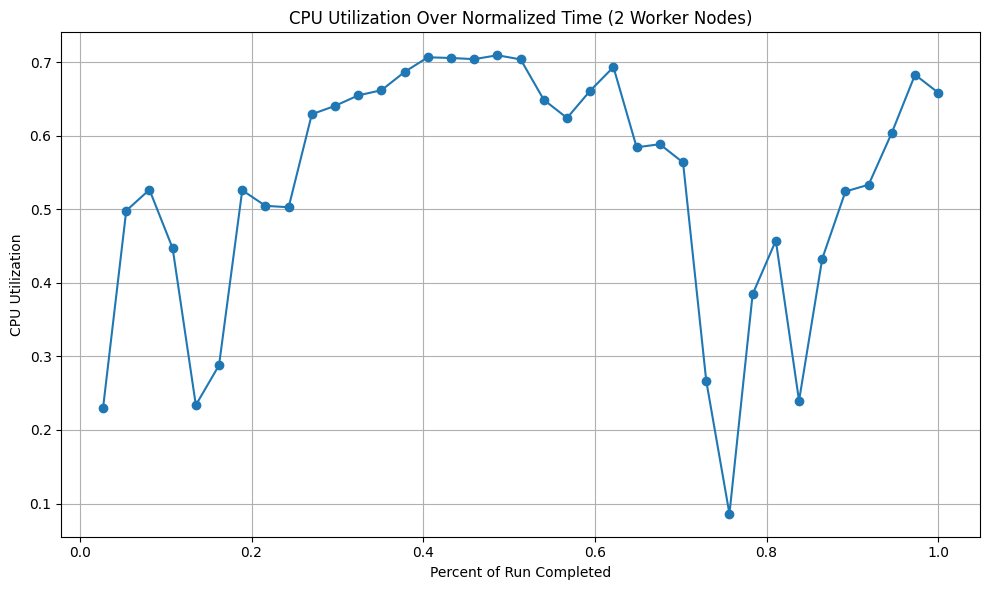

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_2n["pct_through_run"], cpu_2n["cpu_utilization"], marker='o', linestyle='-')

plt.title("CPU Utilization Over Normalized Time (2 Worker Nodes)")
plt.xlabel("Percent of Run Completed")
plt.ylabel("CPU Utilization")
plt.grid(True)

plt.tight_layout()
plt.show()

#### CPU Utilization Summary Statistics

In [ ]:
max_util_2n = cpu_2n["cpu_utilization"].max()
min_util_2n = cpu_2n["cpu_utilization"].min()
avg_util_2n = cpu_2n["cpu_utilization"].mean()

print(f"Max CPU utilization (2 nodes): {max_util_2n:.4f}")
print(f"Min CPU utilization (2 nodes): {min_util_2n:.4f}")
print(f"Avg CPU utilization (2 nodes): {avg_util_2n:.4f}")

Max CPU utilization (2 nodes): 0.7093
Min CPU utilization (2 nodes): 0.0860
Avg CPU utilization (2 nodes): 0.5349


### 3 Worker Nodes

In [ ]:

# Base path and file list
base_path = "..." # path hidden for anonymity 

files = [
    f"{base_path}/CPU_utilization.csv",
    f"{base_path}/CPU_utilization-2.csv",
    f"{base_path}/CPU_utilization-3.csv"
]

# Load and clean each file, uniformly labeled
cpu_runs = []
for fp in files:
    df = pd.read_csv(fp).drop(index=0).reset_index(drop=True)
    df.columns = ["timestamp", "cpu_utilization"]
    df["cpu_utilization"] = pd.to_numeric(df["cpu_utilization"], errors="coerce")
    df["mins_since_start"] = range(1, len(df) + 1)
    df["resource_type"] = "CPU, 3 nodes"
    cpu_runs.append(df)

# Combine all
cpu_all = pd.concat(cpu_runs, ignore_index=True)

# drop specific date 
cpu_all = cpu_all[~cpu_all["timestamp"].str.contains("May 05")].reset_index(drop=True) #accidentally left cluster overnight so drop that day where nothing was happening

# Sort and normalize time
cpu_all = cpu_all.sort_values("timestamp").reset_index(drop=True)
cpu_all["mins_since_start"] = range(1, len(cpu_all) + 1)
cpu_all["pct_through_run"] = cpu_all["mins_since_start"] / cpu_all["mins_since_start"].max()

#### Graph CPU Utilization over Normalized Time

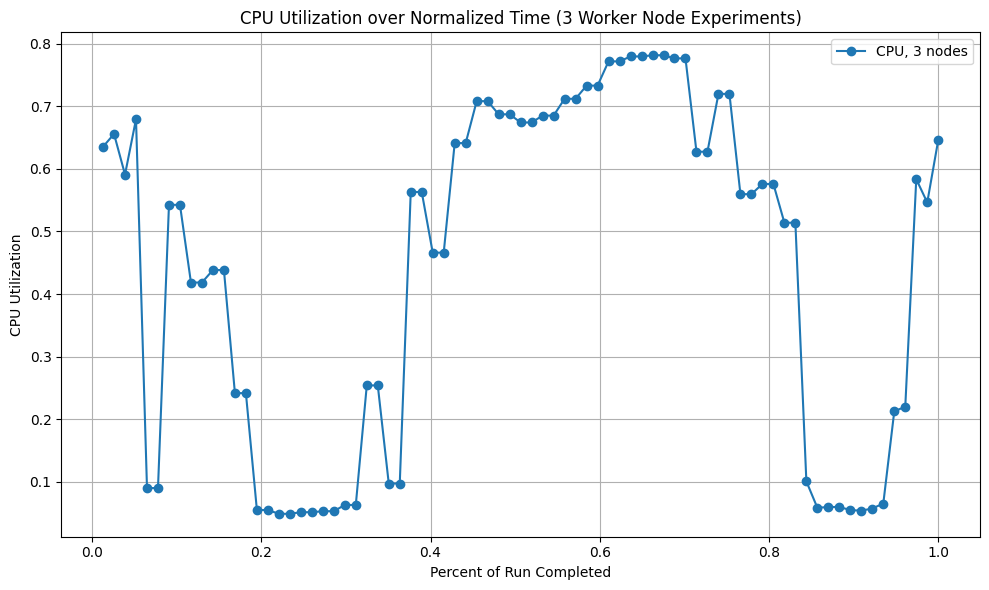

In [ ]:

plt.figure(figsize=(10, 6))

# plot
for label, df in cpu_all.groupby("resource_type"):
    plt.plot(df["pct_through_run"], df["cpu_utilization"], marker='o', linestyle='-', label=label)

plt.title("CPU Utilization over Normalized Time (3 Worker Node Experiments)")
plt.xlabel("Percent of Run Completed")
plt.ylabel("CPU Utilization")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Summary Statistics

In [ ]:
summary = cpu_all.groupby("resource_type")["cpu_utilization"].agg(["min", "max", "mean"]).round(4)
print(summary)

                  min     max    mean
resource_type                        
CPU, 3 nodes   0.0486  0.7818  0.4408


### Discussion

The 2-node cluster demonstrated higher average CPU utilization (53.5% vs. 44.1%). The 2-node run shows more frequent fluctuations in CPU usage, with sharper rises and drops in utilization. In contrast, the 3-node run demonstrates longer periods of sustained low usage, suggesting less volatility but more idle time. While the 2-node setup had a higher average utilization, the 3-node run showed broader periods of underuse.

## Number of read/write operations per second

### 2 Worker Nodes

In [ ]:

# Define base path and file names
base_path_2n = "..." # path hidden for anonymity

read_fp_2n = f"{base_path_2n}/Disk_operations_1.csv"
write_fp_2n = f"{base_path_2n}/Disk_operations_2.csv"

# Load and clean read data
disk_read_2n = pd.read_csv(read_fp_2n).drop(index=0).reset_index(drop=True)
disk_read_2n.columns = ["timestamp", "ops_per_sec"]
disk_read_2n["op_type"] = "read"

# Load and clean write data
disk_write_2n = pd.read_csv(write_fp_2n).drop(index=0).reset_index(drop=True)
disk_write_2n.columns = ["timestamp", "ops_per_sec"]
disk_write_2n["op_type"] = "write"

# Combine both
disk_2n_all = pd.concat([disk_read_2n, disk_write_2n], ignore_index=True)

# Clean numeric and sort
disk_2n_all["ops_per_sec"] = pd.to_numeric(disk_2n_all["ops_per_sec"], errors="coerce")
disk_2n_all = disk_2n_all.sort_values("timestamp").reset_index(drop=True)

# Add minutes since start
disk_2n_all["mins_since_start"] = range(1, len(disk_2n_all) + 1)

disk_2n_all["pct_through_run"] = disk_2n_all["mins_since_start"] / disk_2n_all["mins_since_start"].max()


#### Graph Disk Operations Over Normalized Time (read/write)

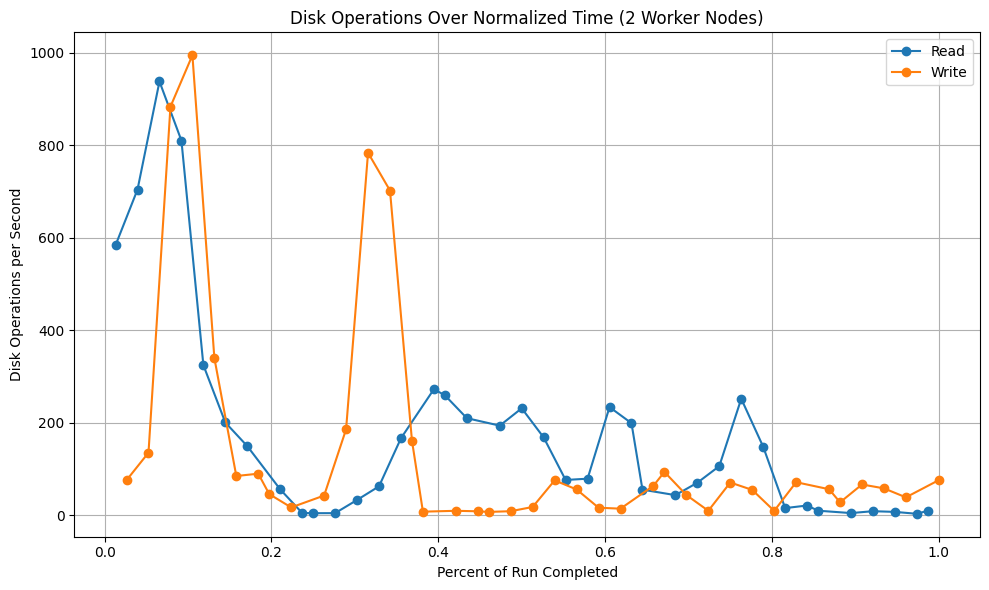

In [ ]:

plt.figure(figsize=(10, 6))

# Plot read and write separately
for op in ["read", "write"]:
    subset = disk_2n_all[disk_2n_all["op_type"] == op]
    plt.plot(subset["pct_through_run"], subset["ops_per_sec"], label=op.capitalize(), marker='o')

plt.title("Disk Operations Over Normalized Time (2 Worker Nodes)")
plt.xlabel("Percent of Run Completed")
plt.ylabel("Disk Operations per Second")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Summary Statistics

In [ ]:
# Summary stats for 2-node disk operations
summary_2n = disk_2n_all.groupby("op_type")["ops_per_sec"].agg(["min", "max", "mean"]).round(4)
print(summary_2n)

            min     max      mean
op_type                          
read     2.7000  937.90  176.5197
write    6.7833  994.65  144.4947


### 3 Worker Nodes

In [ ]:
import pandas as pd

# Base path
base_path = "..." # path hidden for anonymity

# File lists
read_files = [
    f"{base_path}/Disk_operations_1.csv",
    f"{base_path}/Disk_operations_1_2.csv",
    f"{base_path}/Disk_operations_1_3.csv"
]

write_files = [
    f"{base_path}/Disk_operations_2.csv",
    f"{base_path}/Disk_operations_2_2.csv",
    f"{base_path}/Disk_operations_2_3.csv"
]

# Function to load and tag
def load_disk_ops(file_list, op_type):
    dfs = []
    for fp in file_list:
        df = pd.read_csv(fp).drop(index=0).reset_index(drop=True)
        df.columns = ["timestamp", "ops_per_sec"]
        df["op_type"] = op_type
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load all and stack
disk_read = load_disk_ops(read_files, "read")
disk_write = load_disk_ops(write_files, "write")
disk_all = pd.concat([disk_read, disk_write], ignore_index=True)

# Clean and sort
disk_all["ops_per_sec"] = pd.to_numeric(disk_all["ops_per_sec"], errors="coerce")
disk_all = disk_all.sort_values("timestamp").reset_index(drop=True)
disk_all["mins_since_start"] = range(1, len(disk_all) + 1)

disk_all["pct_through_run"] = disk_all["mins_since_start"] / disk_all["mins_since_start"].max()

#### Graph Disk Operations Over Normalized Time (read/write)

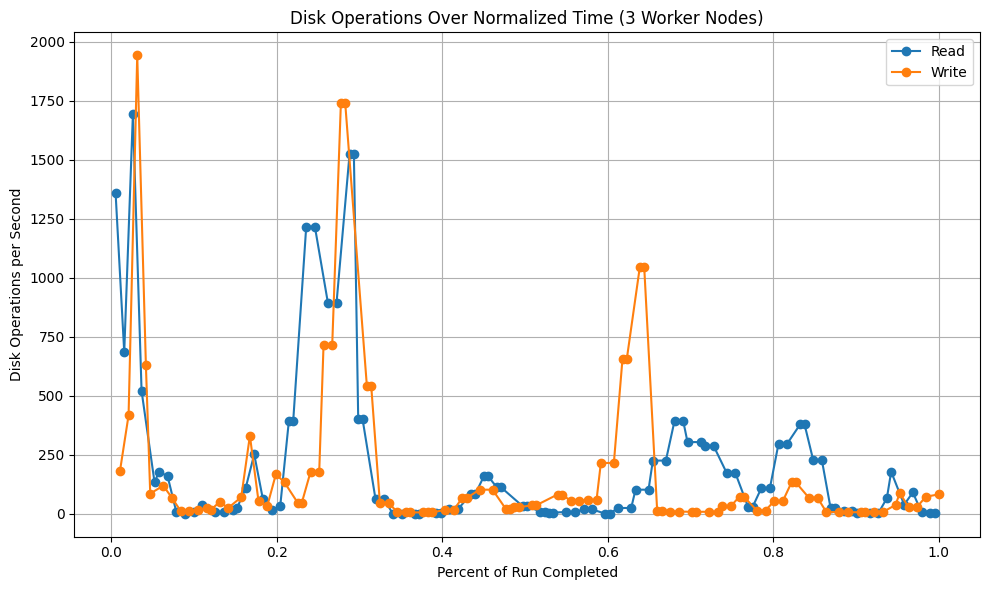

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot read and write lines
for op in ["read", "write"]:
    subset = disk_all[disk_all["op_type"] == op]
    plt.plot(subset["pct_through_run"], subset["ops_per_sec"], label=op.capitalize(), marker='o')

plt.title("Disk Operations Over Normalized Time (3 Worker Nodes)")
plt.xlabel("Percent of Run Completed")
plt.ylabel("Disk Operations per Second")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Summary Statistics

In [ ]:
summary_stats = disk_all.groupby("op_type")["ops_per_sec"].agg(["min", "max", "mean"]).round(4)
print(summary_stats)

            min        max      mean
op_type                             
read     0.0167  1692.9833  216.3498
write    5.9667  1942.8333  178.3582


## Discussion


Disk operations per second (read and write ops/sec) measures how many times the system reads from or writes to disk each second. This matters because high or sudden spikes in disk activity can indicate parts of the workload that are slowed down by waiting on data access rather than computing.

Disk performance improved with more workers: the 3-node setup reached much higher peaks, with reads hitting 1692.98 ops/sec and writes reaching 1942.83 ops/sec, compared to 937.90 and 994.65 ops/sec on the 2-node setup. On average, the 3-node system also handled more disk activity, with 216.35 read and 178.36 write ops/sec, versus 176.52 and 144.49 for 2 nodes.

That said, the 3-node system also had more downtime between bursts—especially for reads, which dropped as low as 0.02 ops/sec. In contrast, the 2-node system did most of its disk work earlier in the run and kept a steadier level of activity, never falling below 2.70 ops/sec for reads.

These results suggest that while adding more nodes gives the system more disk power, the workload doesn’t always use it steadily. Instead, the 3-node setup shows short, intense bursts followed by quiet periods, while the 2-node setup makes more consistent use of the disk over time.

## YARN Allocated Memory Percentage 

### 2 Worker Nodes

In [ ]:
# file 
file_pct_mem_2n = "..." # path hidden for anonymity

# read and clean
mem_2n = pd.read_csv(file_pct_mem_2n)
mem_2n = mem_2n.drop(index=0).reset_index(drop=True)
mem_2n.columns = ["timestamp", "pct_mem"]

# sort by time
mem_2n = mem_2n.sort_values("timestamp").reset_index(drop=True)

# generate mins from start 
mem_2n["mins_since_start"] = range(1, len(mem_2n) + 1)

#normalize time 
mem_2n["pct_through_run"] = mem_2n["mins_since_start"] / mem_2n["mins_since_start"].max()

#### Graph of YARN Memory Utilization Over Normalized Time (2 Worker Nodes)

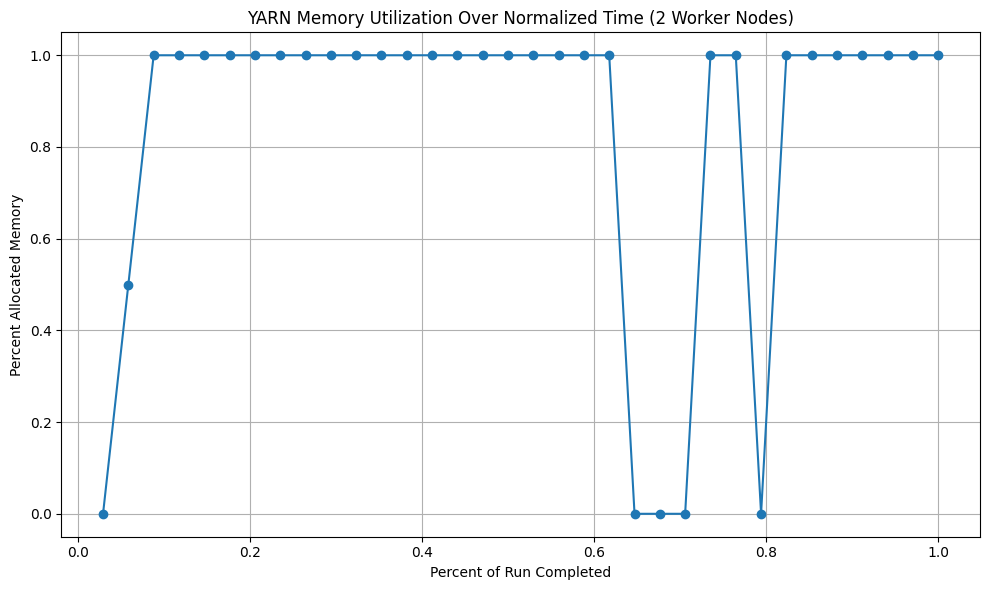

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mem_2n["pct_through_run"], pd.to_numeric(mem_2n["pct_mem"], errors="coerce"), marker='o')

plt.title("YARN Memory Utilization Over Normalized Time (2 Worker Nodes)")
plt.xlabel("Percent of Run Completed")
plt.ylabel("Percent Allocated Memory")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Summary Statistics

In [ ]:
# summary stats
mem_2n["pct_mem"] = pd.to_numeric(mem_2n["pct_mem"], errors="coerce")
summary = mem_2n["pct_mem"].agg(["min", "max", "mean"]).round(4)
print(summary)

# gen pct of time at 100% mem usage since the above graph isn't as useful 
pct_maxed = (mem_2n["pct_mem"] == 1.0).mean()
print(f"Proportion of time at 100% memory usage: {pct_maxed:.2%}")

min     0.0000
max     1.0000
mean    0.8382
Name: pct_mem, dtype: float64
Proportion of time at 100% memory usage: 82.35%


### 3 Worker Nodes

In [ ]:

# files
base_path_3n = "..." # path hidden for anonymity

file_list_3n = [
    f"{base_path_3n}/YARN_allocated_memory_percentage_for_9d7e604b-3a3c-4c17-92b7-0e5bb0a0c82f_[SUM].csv",
    f"{base_path_3n}/YARN_allocated_memory_percentage_for_f771f8d4-d435-453c-8903-01f1e988b451_[SUM].csv",
    f"{base_path_3n}/YARN_allocated_memory_percentage_for_f771f8d4-d435-453c-8903-01f1e988b451_[SUM]-2.csv"
]

# load and clean 
mem_3n_list = []
for fp in file_list_3n:
    df = pd.read_csv(fp).drop(index=0).reset_index(drop=True)
    df.columns = ["timestamp", "pct_mem"]
    mem_3n_list.append(df)

# Stack all cuts
mem_3n = pd.concat(mem_3n_list, ignore_index=True)

# clean and sort 
mem_3n["pct_mem"] = pd.to_numeric(mem_3n["pct_mem"], errors="coerce")
mem_3n = mem_3n.sort_values("timestamp").reset_index(drop=True)
mem_3n["mins_since_start"] = range(1, len(mem_3n) + 1)

# normalize time 
mem_3n["pct_through_run"] = mem_3n["mins_since_start"] / mem_3n["mins_since_start"].max()

#### Graph of YARN Memory Utilization Over Normalized Time (3 Worker Nodes)

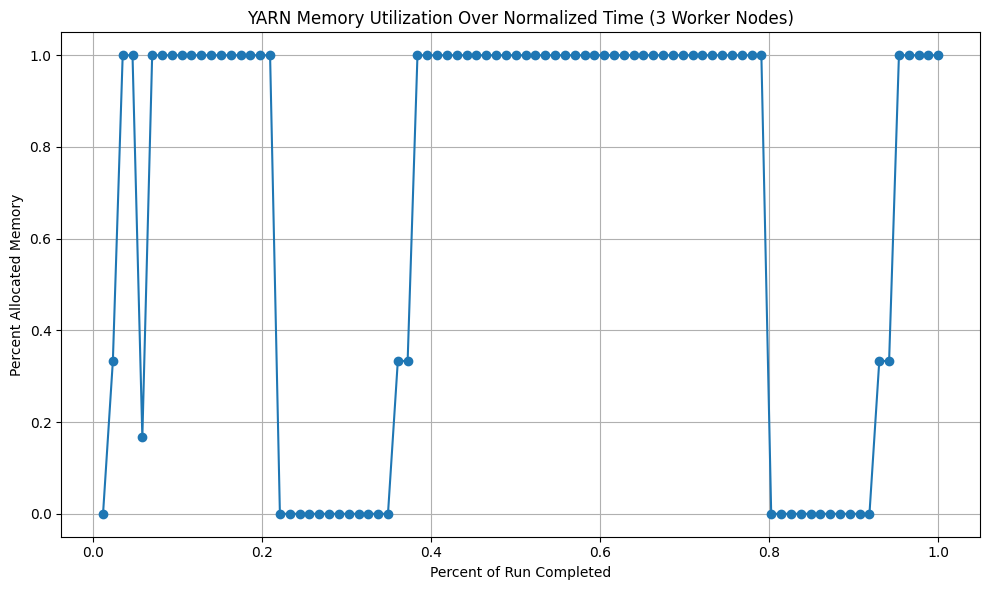

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mem_3n["pct_through_run"], mem_3n["pct_mem"], marker='o')

plt.title("YARN Memory Utilization Over Normalized Time (3 Worker Nodes)")
plt.xlabel("Percent of Run Completed")
plt.ylabel("Percent Allocated Memory")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Summary statistics 

In [ ]:
# summary stats
summary_3n = mem_3n["pct_mem"].agg(["min", "max", "mean"]).round(4)
print("Summary (3 nodes):")
print(summary_3n)

# proportion at 100%
pct_maxed_3n = (mem_3n["pct_mem"] == 1.0).mean()
print(f"Proportion of time at 100% memory usage: {pct_maxed_3n:.2%}")

Summary (3 nodes):
min     0.0000
max     1.0000
mean    0.6725
Name: pct_mem, dtype: float64
Proportion of time at 100% memory usage: 65.12%


YARN memory utilization tracks the proportion of memory allocated to active tasks over time. This matters because when memory usage is consistently at 100%, it can signal a system under strain, with limited room to buffer data or handle new tasks, potentially slowing performance or increasing the chance of failures due to memory pressure.

In the 2-node configuration, memory was maxed out at 100% for 82.35% of the run, with an average utilization of 83.82%. The graph shows a long sustained period of full usage, followed by a brief drop near the latter third of the run. This pattern suggests tight memory conditions throughout, which may have led to more aggressive disk activity or task queuing.

In contrast, the 3-node configuration hit 100% usage 65.12% of the time, with a lower average of 67.25%. The usage was volatile, with more points spiking to full utilization, then dipping to zero or near-zero in several phases. While the 3-node setup had more available memory headroom overall, it didn’t consistently leverage it across the entire job duration.

These results imply that while adding nodes eased memory pressure overall, the system still entered memory-bound phases. The 2-node setup, in particular, likely operated at or near capacity for much of the workload, which may have impacted performance elsewhere, like disk or CPU.